## Task 2
Implement a circuit that returns |01> and |10> with equal probability (50% for each).
Requirements :
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
- Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

#### Bonus question:
How to make sure you produce state |01> + |10> and not |01> - |10> ?

## Problem Understanding
#### The layman way of creating any entangles state is using follwing quantum gates:
- 1 H gate
- 1 CX gate
- X/Z gate(s) (if required) 

#### Here task is 
1. to use only RX, RY and CNOT gates (1 or more each)
2. paramaterize the angles of RX and RY
3. Optimize the parameters Using Stochastic gradient descent for hybrid quantum-classical optimization

#### These type of ciruits/algorithms are also known as Variational Quantum Computation

## Approach

### 1. Create Vanilla Circuit
    - Use H, X and CX quantum gates
    - Visualize it on Qsphere
    - Convert the quantum gates to restricted set of quantum gates
    - Visualize it on Qsphere

### 2. Create Parameteized Circuit
    - Set Initial state to |00>
    - set All angles to 0
    - train using gradient descent
    
### 3. Figure out approach for producing state $|01\rangle$ + $|10\rangle$ and not $|01\rangle$ - $|10\rangle$ 

### 4. Test final approach for different number of measurements

#### Note: I mostly use the bloch sphere for visualization, as these enable us to see both the state and the phases associated. For final test case, One can see both bar plot and bloch sphere statevector representation.
    

In [1]:
# ALl imports go here
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_qsphere
import numpy as np

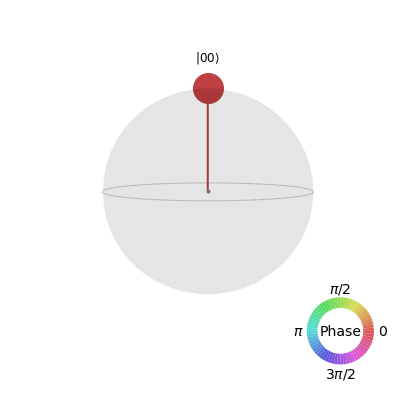

In [2]:
# Initialize Vanilla Circuit
vanilla_circuit = QuantumCircuit(2)
# Check input state
plot_state_qsphere(Statevector.from_instruction(vanilla_circuit))

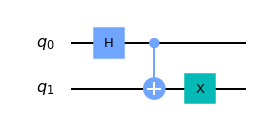

In [3]:
# introduce entanglement
vanilla_circuit.h(0)
vanilla_circuit.cnot(0,1)
# flip one bit
vanilla_circuit.x(1)
# plot the circuit
vanilla_circuit.draw('mpl')

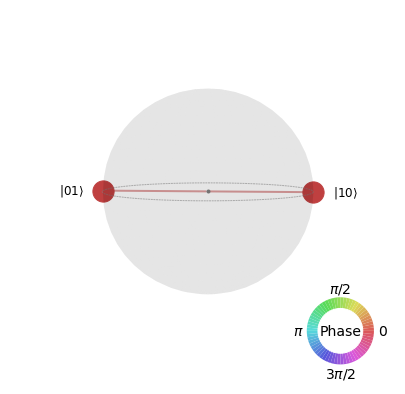

In [4]:
# Check output state
plot_state_qsphere(Statevector.from_instruction(vanilla_circuit))

### Now this circuit represents the euivalent of desired circuit from fumctionality standpoint

Let's change the gates used to allowed set of gates.
- We can have the effect of H gate using a Rotation of π around X followed by Rotation of -π/2 around Y
- CNOT is allowed in final circuit
- X gate is nothing but RX with θ=π


In [5]:
def create_circuit(parameters):
    c = QuantumCircuit(2)
    # apply rx(π,0) and ry(-π/2,0) to simulate H gate
    c.rx(parameters[0],0)
    c.ry(parameters[1],0)
    # apply cnot
    c.cnot(0,1)
    # apply rx in place of x on qubit 1
    c.rx(parameters[2],1)
    return c

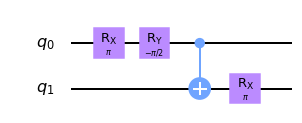

In [6]:
params = [np.pi,-1/2*np.pi,np.pi]
converted_circuit = create_circuit(params)
# draw the circuit
converted_circuit.draw('mpl')

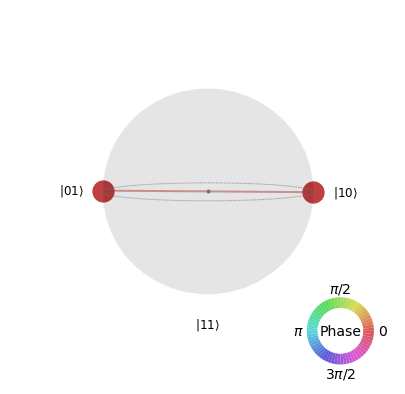

In [7]:
# plot state vector of output on qsphere
plot_state_qsphere(Statevector.from_instruction(converted_circuit))

We can see that the output is still 1/√2 ( |01> + |10> )

### Let's now parameterize the circuit

In [8]:
from qiskit import *
import pennylane as qml
from qiskit.providers.aer.noise import NoiseModel

In [9]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')

/home/sagar/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [10]:
noise_model = NoiseModel.from_backend(backend)
node = qml.device('qiskit.aer', wires=2, shots=1000, noise_model = noise_model, analytic=False)

In [11]:
@qml.qnode(node)
def run_circuit_and_get_probs(parameters):
    qml.RX(parameters[0],wires=0)
    qml.RY(parameters[1],wires=0)
    qml.CNOT(wires=[0,1])
    qml.RX(parameters[2],wires=0)
    return qml.probs(wires=[0,1])

In [12]:
def gradient(parameters):
    p_00, p_01, p_10, p_11 = run_circuit_and_get_probs(parameters)
    return (p_00**2 + p_11**2 + (p_01-0.5)**2 + (p_10-0.5)**2)

In [13]:
def get_circuit_info(params, circuit=run_circuit_and_get_probs, cost_function=gradient):
    print('parameters\t\t',params)
    print('probabilities\t\t',circuit(params))
    print('cost\t\t\t',cost_function(params))    

In [14]:
def visualize_circuit(params, vanilla_circuit=create_circuit):
    circuit = vanilla_circuit(params)
    print(circuit.draw())
    return plot_state_qsphere(Statevector.from_instruction(circuit))

parameters		 [0, 0, 0]
probabilities		 [0.993 0.005 0.002 0.   ]
cost			 1.479074
     ┌───────┐┌───────┐              
q_0: ┤ RX(0) ├┤ RY(0) ├──■───────────
     └───────┘└───────┘┌─┴─┐┌───────┐
q_1: ──────────────────┤ X ├┤ RX(0) ├
                       └───┘└───────┘


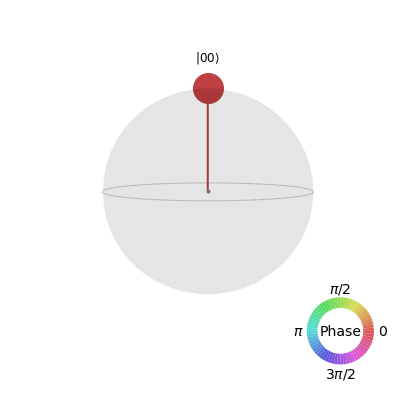

In [15]:
inital_p = [0,0,0]
get_circuit_info(inital_p)
visualize_circuit(inital_p)

parameters		 [3.141592653589793, -1.5707963267948966, 3.141592653589793]
probabilities		 [0.038 0.478 0.481 0.003]
cost			 0.0024299999999999986
     ┌────────┐┌───────────┐               
q_0: ┤ RX(pi) ├┤ RY(-pi/2) ├──■────────────
     └────────┘└───────────┘┌─┴─┐┌────────┐
q_1: ───────────────────────┤ X ├┤ RX(pi) ├
                            └───┘└────────┘


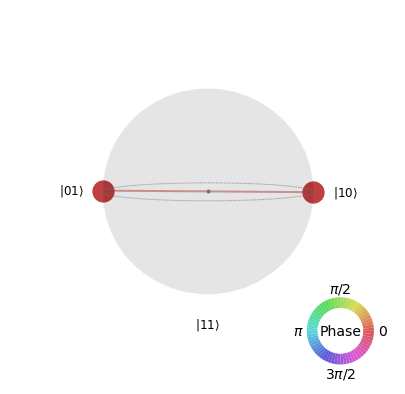

In [16]:
ideal_p = [np.pi,-1/2*np.pi,np.pi]
get_circuit_info(ideal_p)
visualize_circuit(ideal_p)

In [17]:
def optimize(sampling_size=100, 
             step_size=0.1, 
             circuit=run_circuit_and_get_probs,
             cost_function=gradient, 
             learning_steps=100, 
             node=node, 
             initialize='zeors', 
             parameters=[0,0,0]):
    logging_step = 10
    node.shots = sampling_size
    optimizer = qml.GradientDescentOptimizer(stepsize=step_size)
    if(initialize=='random'): parameters = np.random.randn(3)
    for i in range(learning_steps):
        parameters = optimizer.step(cost_function,parameters)
        if ((i+1)%logging_step == 0):
            print('Step #',i+1,'of total', learning_steps,'steps.')
            get_circuit_info(parameters, circuit=circuit, cost_function=cost_function)
    return parameters

In [18]:
params = optimize(sampling_size=100)

Step # 10 of total 100 steps.
parameters		 [-0.009530000000000004, 0.06444, 0.06732999999999999]
probabilities		 [1. 0. 0. 0.]
cost			 1.4405999999999999
Step # 20 of total 100 steps.
parameters		 [-0.041429999999999995, 0.13447, 0.32847000000000004]
probabilities		 [0.98 0.   0.02 0.  ]
cost			 1.2634
Step # 30 of total 100 steps.
parameters		 [-0.044459999999999986, 0.33757000000000004, 1.03986]
probabilities		 [0.76 0.02 0.2  0.02]
cost			 0.7921999999999999
Step # 40 of total 100 steps.
parameters		 [-0.038449999999999984, 0.5066700000000001, 1.68378]
probabilities		 [0.43 0.02 0.49 0.06]
cost			 0.4042
Step # 50 of total 100 steps.
parameters		 [-0.06982999999999999, 0.7328200000000001, 1.9789200000000002]
probabilities		 [0.33 0.11 0.52 0.04]
cost			 0.24440000000000006
Step # 60 of total 100 steps.
parameters		 [-0.08206999999999999, 1.01282, 2.1491800000000003]
probabilities		 [0.21 0.11 0.55 0.13]
cost			 0.15239999999999998
Step # 70 of total 100 steps.
parameters		 [-0.09705

parameters		 [-0.10799000000000003, 1.5722500000000001, 2.5404599999999986]
probabilities		 [0.07 0.54 0.35 0.04]
cost			 0.025400000000000002
     ┌──────────────┐┌────────────┐                   
q_0: ┤ RX(-0.10799) ├┤ RY(1.5723) ├──■────────────────
     └──────────────┘└────────────┘┌─┴─┐┌────────────┐
q_1: ──────────────────────────────┤ X ├┤ RX(2.5405) ├
                                   └───┘└────────────┘


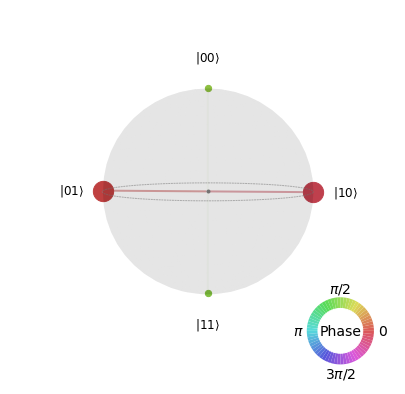

In [19]:
get_circuit_info(params)
visualize_circuit(params)

#### We can see that the final resultant state has associated unwanted phase 

#### The phase e^(iθ) is due to the fact that the probability does not depend upon this phase.

Hence we can have any of these 4 phases (+1, -1, +i, and -i)

#### Steps that we can take to distinguish +i, -i phases i.e. (|0> + i|1>) and (|0> - i|1>)
- Change the measurement basis to X@Y (PauliX measurement on qubit_0 and PauliY on qubit_1)
- This will give us following average measurments:
    - -1 on phase +i
    - +1 on phase -i
    - 0 on phase +1 and -1

#### Steps that we can take to distinguish +1, -1 phases i.e. (|0> + |1>) and (|0> - |1>)
- Change the measurement basis to X@X (PauliX measurement on both qubit_0 and qubit_1)
- Or change the measurement basis to Y@Y (PauliY measurement on both qubit_0 and qubit_1)
- This will give us following average measurments:
    - +1 on phase +1
    - -1 on phase -1
    - 0 on phase +i and -i


#### To combine both results to distinguish +1 phase from other phases
- Create a quantum node collection for 2 nodes of the same circuit
    - node_1 will return X@X or Y@Y
    - node_2 will return X@Y
- Alter the gradient function
    - cost = |X@Y|-X@X + gradient()

## We can think of more alternate/optimized ways as well for doing same. One such way is:
- Eleminate +i, -i phases by not using the RX gates at all. Only 2 RY, 1 CNOT gates will suffice, hence less complex model
- Distinguish +1, -1 phase using X@X. Only one node required, hence less cost
- The parameteric angles for both RY gates in ideal situation are in ratio 1:2, which can enable us to use only one parameter for training, hence further reduction in complexity

#### Steps that we can take to get rid of +i, -i phases: 
- Don't use RX gates, as they provide the complex amplitudes
- We can produce effect of Hadamard gate by using the RY(π/2) on a given qubit
- Similarly, we can produce the effect of X usnig RY(π) on a given qubit


## Observations to make:
- The order of gate doesn't matter when we parameterize and train it using gradient descent optimization
- From visualization point of view, we now are reducing our possible states from entire bloch sphere to the XZ-circlular locus. Hence now the possible phases are only (+1, -1)

## Why to swich to the Pauli measurements?

The point here is that in standard basis we are not able to point out any difference between the nuemerous possible states.
The Pauli_X measurement is similar to measuring in `|+> and |->` basis. As the Pauli_X matrix is 

$\begin{split}\sigma_x = \begin{bmatrix} 0 & 1 \\ 1 & 0\end{bmatrix}\end{split}$

Hence this will convert the `|0> to |1>` and `|1> to |0>` , Hence also called `bit flip` or `X` or `quantum NOT` gate. This gate performs a rotation of pi units around `|+>` state in hilbert space. That means `|+>` state is one eigen vector with `eigenvalue 1` and `|->` state is another eigenvector with `eigenvalue -1`.

$\begin{split}\sigma_x \otimes \sigma_x = \begin{bmatrix} 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \end{bmatrix}\end{split}$

So this will convert `|00> to |11>`, `|01> to |10>`, `|10> to |01>` and `|11> to |00>`

- In our case, if we change state: `|01> + |10>`, we get `|01> +|10>`
- Similarly, `|01> - |10>` for we get `|10> - |01>`, notice an overall phase of -1
- So these are 2 of 4 eigen vectors with eigenvalues = +1 and -1 respectively.


## Let's observe approach 1

In [20]:
@qml.qnode(node)
def run_circuit_and_measure_PauliX_X(parameters):
    qml.RX(parameters[0],wires=0)
    qml.RY(parameters[1],wires=0)
    qml.CNOT(wires=[0,1])
    qml.RX(parameters[2],wires=0)
    return qml.expval(qml.PauliX(0)@qml.PauliX(1))
#     Same result for Y@Y
#     return qml.expval(qml.PauliY(0)@qml.PauliY(1))

In [21]:
@qml.qnode(node)
def run_circuit_and_measure_PauliX_Y(parameters):
    qml.RX(parameters[0],wires=0)
    qml.RY(parameters[1],wires=0)
    qml.CNOT(wires=[0,1])
    qml.RX(parameters[2],wires=0)
    return qml.expval(qml.PauliX(0)@qml.PauliY(1))

0.96
-0.08
     ┌────────┐┌───────────┐               
q_0: ┤ RX(pi) ├┤ RY(-pi/2) ├──■────────────
     └────────┘└───────────┘┌─┴─┐┌────────┐
q_1: ───────────────────────┤ X ├┤ RX(pi) ├
                            └───┘└────────┘


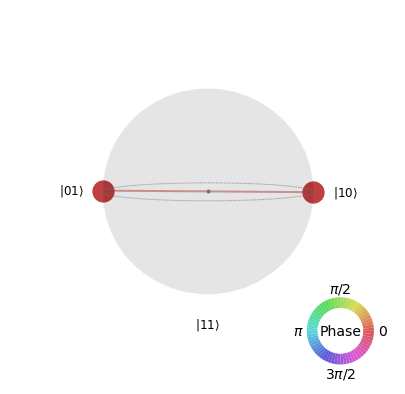

In [22]:
# angles for |01> + |10> 
plus_1 = [np.pi, -np.pi/2, np.pi]
# Perform measurments
print(run_circuit_and_measure_PauliX_X(plus_1))
print(run_circuit_and_measure_PauliX_Y(plus_1))
# Visualize |01> + |10> 
visualize_circuit((plus_1))

-0.88
-0.08
     ┌────────┐┌──────────┐               
q_0: ┤ RX(pi) ├┤ RY(pi/2) ├──■────────────
     └────────┘└──────────┘┌─┴─┐┌────────┐
q_1: ──────────────────────┤ X ├┤ RX(pi) ├
                           └───┘└────────┘


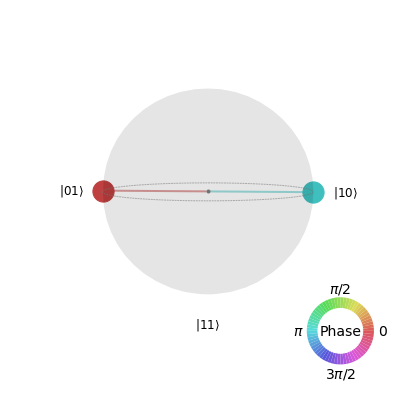

In [23]:
# angles for |01> - |10> 
minus_1 = [np.pi, np.pi/2, np.pi]
# Perform measurments
print(run_circuit_and_measure_PauliX_X(minus_1))
print(run_circuit_and_measure_PauliX_Y(minus_1))
# Visualize |01> + |10> 
visualize_circuit((minus_1))

0.08
-0.94
     ┌──────────┐┌────────┐               
q_0: ┤ RX(pi/2) ├┤ RY(pi) ├──■────────────
     └──────────┘└────────┘┌─┴─┐┌────────┐
q_1: ──────────────────────┤ X ├┤ RX(pi) ├
                           └───┘└────────┘


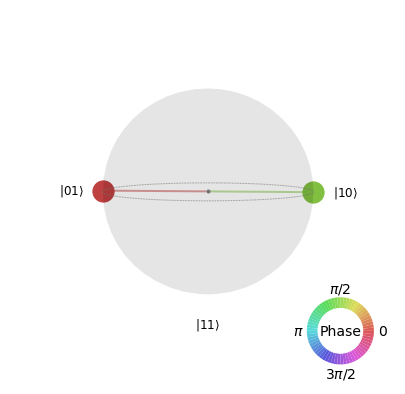

In [24]:
# angles for |01> + i|10> 
plus_i = [np.pi/2, np.pi, np.pi]
# Perform measurments
print(run_circuit_and_measure_PauliX_X(plus_i))
print(run_circuit_and_measure_PauliX_Y(plus_i))
# Visualize |01> + |10> 
visualize_circuit((plus_i))

0.04
0.9
     ┌───────────┐┌───────────┐               
q_0: ┤ RX(-pi/2) ├┤ RY(-pi/2) ├──■────────────
     └───────────┘└───────────┘┌─┴─┐┌────────┐
q_1: ──────────────────────────┤ X ├┤ RX(pi) ├
                               └───┘└────────┘


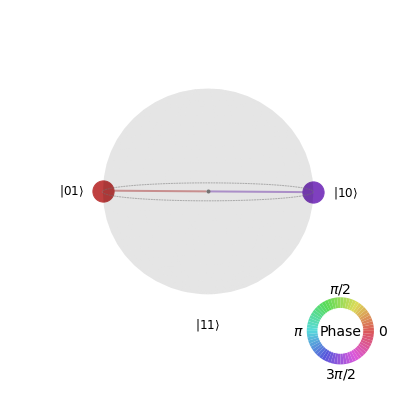

In [25]:
# angles for |01> - i|10> 
minus_i = [-np.pi/2, -np.pi/2, np.pi]
# Perform measurments
print(run_circuit_and_measure_PauliX_X(minus_i))
print(run_circuit_and_measure_PauliX_Y(minus_i))
# Visualize |01> + |10> 
visualize_circuit((minus_i))

In [26]:
nodes = qml.QNodeCollection([run_circuit_and_measure_PauliX_X, 
                             run_circuit_and_measure_PauliX_Y])

In [27]:
def pauli_cost(parameters):
    X_X, X_Y = nodes(parameters)
    p_00, p_01, p_10, p_11 = run_circuit_and_get_probs(parameters)
    return (1 # to make cost between 0 and 1
            -(1*(X_X)) # for +1 and -1 phase
            +(np.absolute(X_Y)) # for +i and -i phase
            +(p_00**2 + p_11**2 + (p_01-0.5)**2 + (p_10-0.5)**2) # for prob of |00> + |11>
           )/2 # to make cost between 0 and 1

In [28]:
phases = [plus_1, minus_1, plus_i, minus_i]
for p in phases:
    measurement = []
    for i in range(100):
        measurement.append(pauli_cost((p)))
    print(np.sum(measurement)/100)

0.08291100000000001
0.996931
0.9587340000000001
0.9594750000000001


In [29]:
params = optimize(step_size=0.2, sampling_size=10, cost_function=pauli_cost)

Step # 10 of total 100 steps.
parameters		 [0.07100000000000001, 1.0540000000000003, -0.001999999999999974]
probabilities		 [0.8 0.  0.  0.2]
cost			 0.8900000000000001
Step # 20 of total 100 steps.
parameters		 [-0.19600000000000004, 1.5010000000000006, -0.10199999999999998]
probabilities		 [0.7 0.  0.  0.3]
cost			 0.5900000000000001
Step # 30 of total 100 steps.
parameters		 [0.040999999999999995, 1.6950000000000007, 0.036000000000000046]
probabilities		 [0.5 0.  0.  0.5]
cost			 0.8400000000000001
Step # 40 of total 100 steps.
parameters		 [-0.21200000000000005, 1.5950000000000006, 0.29100000000000004]
probabilities		 [0.5 0.  0.2 0.3]
cost			 0.71
Step # 50 of total 100 steps.
parameters		 [0.19899999999999993, 1.5660000000000007, 0.6970000000000002]
probabilities		 [0.4 0.  0.  0.6]
cost			 0.4600000000000001
Step # 60 of total 100 steps.
parameters		 [0.046999999999999924, 1.6380000000000008, 1.3030000000000002]
probabilities		 [0.2 0.3 0.3 0.2]
cost			 0.39
Step # 70 of total 1

parameters		 [-0.06400000000000004, 1.6200000000000008, 2.351]
probabilities		 [0.2 0.2 0.6 0. ]
cost			 0.060000000000000005
     ┌────────────┐┌──────────┐                  
q_0: ┤ RX(-0.064) ├┤ RY(1.62) ├──■───────────────
     └────────────┘└──────────┘┌─┴─┐┌───────────┐
q_1: ──────────────────────────┤ X ├┤ RX(2.351) ├
                               └───┘└───────────┘


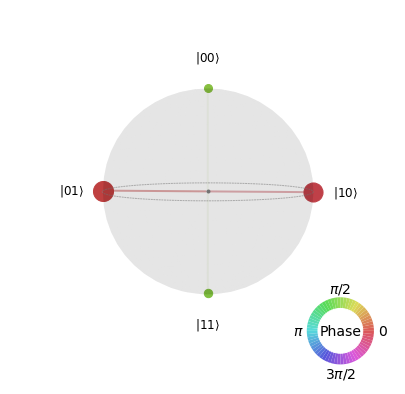

In [30]:
get_circuit_info(params)
visualize_circuit(params)

### This approach is working fine, still to reduce the complexity and training time, let's implement Approach 2 as well

In [31]:
# Vanilla circuit without RX
def create_circuit2(angle):
    vanilla_circuit = QuantumCircuit(2)
    vanilla_circuit.ry(angle, 0)
    vanilla_circuit.ry(2*angle,1)
    vanilla_circuit.cnot(0,1)
    return vanilla_circuit

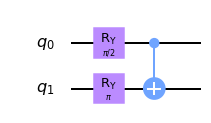

In [32]:
c2 = create_circuit2(np.pi/2)
c2.draw('mpl')

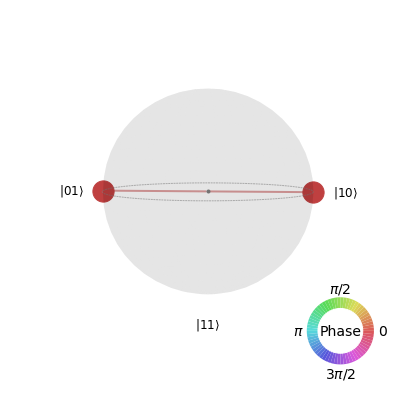

In [33]:
# Visualize the state
plot_state_qsphere(Statevector.from_instruction(c2))

### Let's parameterize this circuit

In [34]:
# create X@X measurment node for the new circuit
@qml.qnode(node)
def run_circuit2_and_measure_PauliX_X(angle):
    qml.RY(angle,wires=0)
    qml.RY(2*angle,wires=1)
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.PauliX(0)@qml.PauliX(1))

In [35]:
# Create same node for prob measuremnt
@qml.qnode(node)
def run_circuit2_and_measure_prob(angle):
    qml.RY(angle,wires=0)
    qml.RY(2*angle,wires=1)
    qml.CNOT(wires=[0,1])
    return qml.probs(wires=[0,1])

In [36]:
# Implement cost function
def pauli_x_cost(angle):
    X_X = run_circuit2_and_measure_PauliX_X(angle)
    p_00, p_01, p_10, p_11 = run_circuit2_and_measure_prob(angle)
    return (1 # to make cost between 0 and 1
            +(p_00**2 + p_11**2 + (p_01-0.5)**2 + (p_10-0.5)**2) # for prob
            -(1*(X_X)) # for +1 and -1 phase
           )/2 # to make cost between 0 and 1

parameters		 1.5707963267948966
probabilities		 [0.  0.3 0.7 0. ]
cost			 0.0
     ┌──────────┐     
q_0: ┤ RY(pi/2) ├──■──
     └┬────────┬┘┌─┴─┐
q_1: ─┤ RY(pi) ├─┤ X ├
      └────────┘ └───┘


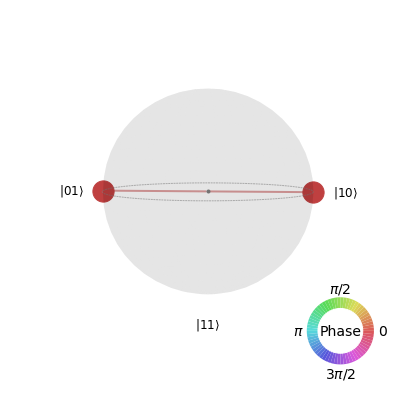

In [37]:
angle=np.pi/2
get_circuit_info(angle, circuit=run_circuit2_and_measure_prob, cost_function=pauli_x_cost)
visualize_circuit(angle, vanilla_circuit=create_circuit2)

## Last step is to compare the results for 1, 10, 100, 1000 samples per iteration
#### Let's optimize this final circuit for all sampling sizes



Training started for circuit with sampling_size 1
##############################################

Step # 10 of total 100 steps.
parameters		 0.675
probabilities		 [0. 0. 1. 0.]
cost			 0.75
Step # 20 of total 100 steps.
parameters		 1.2000000000000002
probabilities		 [1. 0. 0. 0.]
cost			 1.75
Step # 30 of total 100 steps.
parameters		 1.4250000000000003
probabilities		 [0. 1. 0. 0.]
cost			 0.25
Step # 40 of total 100 steps.
parameters		 1.2500000000000007
probabilities		 [0. 1. 0. 0.]
cost			 0.25
Step # 50 of total 100 steps.
parameters		 1.450000000000001
probabilities		 [0. 0. 1. 0.]
cost			 0.25
Step # 60 of total 100 steps.
parameters		 1.4750000000000014
probabilities		 [0. 1. 0. 0.]
cost			 0.25
Step # 70 of total 100 steps.
parameters		 1.5250000000000015
probabilities		 [0. 1. 0. 0.]
cost			 0.25
Step # 80 of total 100 steps.
parameters		 1.5000000000000016
probabilities		 [0. 0. 1. 0.]
cost			 0.25
Step # 90 of total 100 steps.
parameters		 1.5750000000000017
probabilitie

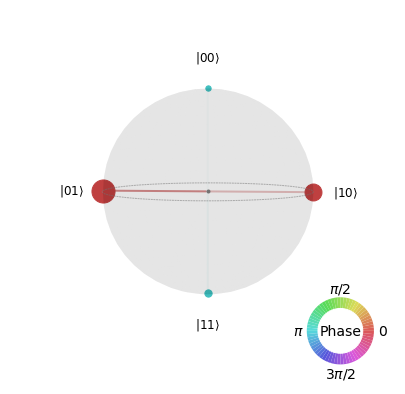

In [38]:
sampling_size=1
initial_angle=0.0
print('\n\nTraining started for circuit with sampling_size',sampling_size)
print('##############################################\n')
trained_angle = optimize(sampling_size=sampling_size, 
                         step_size=0.1, 
                         circuit=run_circuit2_and_measure_prob, 
                         cost_function=pauli_x_cost, 
                         parameters=initial_angle)
print('\n')
# Visualize results for 1 sample per cycle
get_circuit_info(trained_angle, circuit=run_circuit2_and_measure_prob, cost_function=pauli_x_cost)
visualize_circuit(trained_angle, vanilla_circuit=create_circuit2)

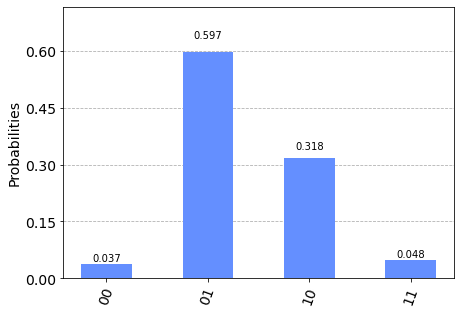

In [39]:
# Plot results for 1 sample per cycle
sv = Statevector.from_instruction(create_circuit2(trained_angle))
counts = sv.sample_counts(shots=1000)
plot_histogram(counts)



Training started for circuit with sampling_size 10
##############################################

Step # 10 of total 100 steps.
parameters		 0.8925
probabilities		 [0.6 0.3 0.1 0. ]
cost			 0.47000000000000003
Step # 20 of total 100 steps.
parameters		 1.3365
probabilities		 [0.  0.4 0.6 0. ]
cost			 0.06999999999999995
Step # 30 of total 100 steps.
parameters		 1.474
probabilities		 [0.2 0.4 0.4 0. ]
cost			 0.13
Step # 40 of total 100 steps.
parameters		 1.514
probabilities		 [0.  0.6 0.4 0. ]
cost			 0.040000000000000036
Step # 50 of total 100 steps.
parameters		 1.5564999999999998
probabilities		 [0.  0.6 0.4 0. ]
cost			 0.13
Step # 60 of total 100 steps.
parameters		 1.6259999999999997
probabilities		 [0.  0.6 0.4 0. ]
cost			 0.010000000000000009
Step # 70 of total 100 steps.
parameters		 1.5449999999999997
probabilities		 [0.  0.5 0.5 0. ]
cost			 0.13
Step # 80 of total 100 steps.
parameters		 1.5639999999999998
probabilities		 [0.  0.5 0.5 0. ]
cost			 0.09999999999999998


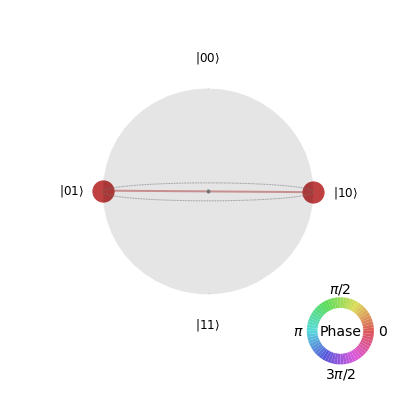

In [40]:
sampling_size=10
print('\n\nTraining started for circuit with sampling_size',sampling_size)
print('##############################################\n')
trained_angle_10 = optimize(sampling_size=sampling_size, 
                         step_size=0.1, 
                         circuit=run_circuit2_and_measure_prob, 
                         cost_function=pauli_x_cost, 
                         parameters=initial_angle)
print('\n')
# Visualize results for 10 sample per cycle
get_circuit_info(trained_angle_10, circuit=run_circuit2_and_measure_prob, cost_function=pauli_x_cost)
visualize_circuit(trained_angle_10, vanilla_circuit=create_circuit2)

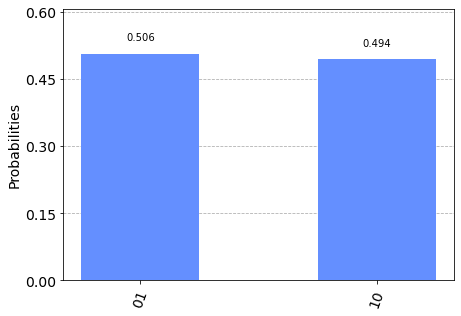

In [45]:
# Plot results for 10 sample per cycle
sv = Statevector.from_instruction(create_circuit2(trained_angle_10))
counts = sv.sample_counts(shots=1000)
plot_histogram(counts)



Training started for circuit with sampling_size 100
##############################################

Step # 10 of total 100 steps.
parameters		 0.948475
probabilities		 [0.34 0.46 0.16 0.04]
cost			 0.18350000000000005
Step # 20 of total 100 steps.
parameters		 1.335915
probabilities		 [0.06 0.57 0.35 0.02]
cost			 0.06649999999999995
Step # 30 of total 100 steps.
parameters		 1.4460949999999995
probabilities		 [0.02 0.62 0.36 0.  ]
cost			 0.05670000000000003
Step # 40 of total 100 steps.
parameters		 1.5016049999999996
probabilities		 [0.01 0.41 0.58 0.  ]
cost			 0.0519
Step # 50 of total 100 steps.
parameters		 1.5016399999999994
probabilities		 [0.03 0.39 0.57 0.01]
cost			 0.03490000000000004
Step # 60 of total 100 steps.
parameters		 1.5085949999999992
probabilities		 [0.03 0.45 0.5  0.02]
cost			 0.054900000000000004
Step # 70 of total 100 steps.
parameters		 1.502639999999999
probabilities		 [0.04 0.57 0.39 0.  ]
cost			 0.04189999999999999
Step # 80 of total 100 steps.
param

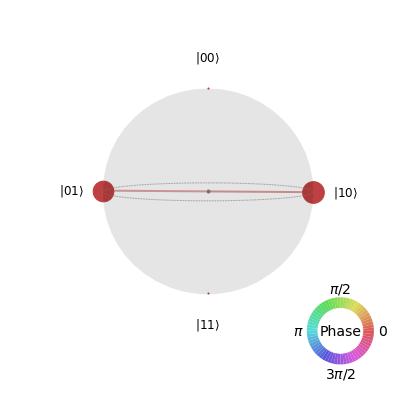

In [46]:
sampling_size=100
print('\n\nTraining started for circuit with sampling_size',sampling_size)
print('##############################################\n')
trained_angle_100 = optimize(sampling_size=sampling_size, 
                         step_size=0.1, 
                         circuit=run_circuit2_and_measure_prob, 
                         cost_function=pauli_x_cost, 
                         parameters=initial_angle)
print('\n')
# Visualize results for 100 sample per cycle
get_circuit_info(trained_angle_100, circuit=run_circuit2_and_measure_prob, cost_function=pauli_x_cost)
visualize_circuit(trained_angle_100, vanilla_circuit=create_circuit2)

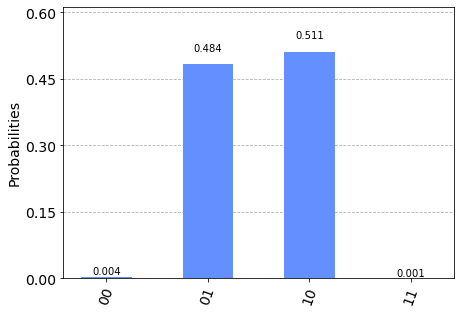

In [47]:
# Plot results for 100 sample per cycle
sv = Statevector.from_instruction(create_circuit2(trained_angle_100))
counts = sv.sample_counts(shots=1000)
plot_histogram(counts)



Training started for circuit with sampling_size 1000
##############################################

Step # 10 of total 100 steps.
parameters		 0.9793814000000002
probabilities		 [0.259 0.498 0.153 0.09 ]
cost			 0.224333
Step # 20 of total 100 steps.
parameters		 1.3493203
probabilities		 [0.053 0.551 0.375 0.021]
cost			 0.05192000000000002
Step # 30 of total 100 steps.
parameters		 1.4559217500000001
probabilities		 [0.037 0.539 0.417 0.007]
cost			 0.046126999999999974
Step # 40 of total 100 steps.
parameters		 1.5039550000000002
probabilities		 [0.035 0.501 0.455 0.009]
cost			 0.04310799999999998
Step # 50 of total 100 steps.
parameters		 1.5103814500000003
probabilities		 [0.037 0.52  0.439 0.004]
cost			 0.041454999999999964
Step # 60 of total 100 steps.
parameters		 1.5272437
probabilities		 [0.038 0.478 0.481 0.003]
cost			 0.036596999999999935
Step # 70 of total 100 steps.
parameters		 1.5301255
probabilities		 [0.036 0.52  0.439 0.005]
cost			 0.050055999999999934
Step # 

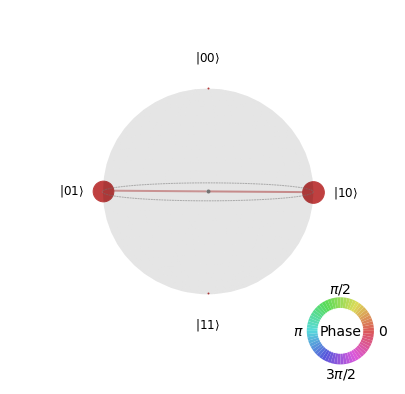

In [48]:
sampling_size=1000
print('\n\nTraining started for circuit with sampling_size',sampling_size)
print('##############################################\n')
trained_angle_1000 = optimize(sampling_size=sampling_size, 
                         step_size=0.1, 
                         circuit=run_circuit2_and_measure_prob, 
                         cost_function=pauli_x_cost, 
                         parameters=initial_angle)
print('\n')
# Visualize results for 1000 sample per cycle
get_circuit_info(trained_angle_1000, circuit=run_circuit2_and_measure_prob, cost_function=pauli_x_cost)
visualize_circuit(trained_angle_1000, vanilla_circuit=create_circuit2)

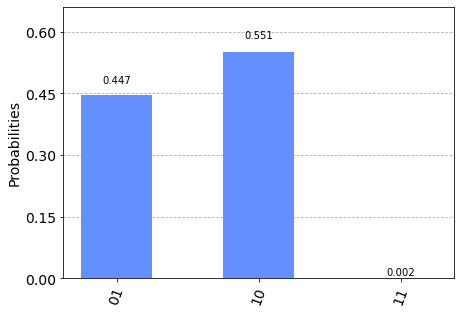

In [49]:
# Plot results for 1000 sample per cycle
sv = Statevector.from_instruction(create_circuit2(trained_angle_1000))
counts = sv.sample_counts(shots=1000)
plot_histogram(counts)

# Conclusion:

The results for first run on same optimizer for same parameters are as follow:

| Number of samples per cycle | Prob_00 | Prob_01 |	Prob_10 | Prob_11 | Trained angle |
| --- | --- | --- | --- | --- | --- |
| 1 | 0.016 | 0.421 | 0.551 | 0.012 | 1.425 |
| 10 | 0.001 | 0.453 | 0.545 | 0.001 | 1.5055 |
| 100 | 0.002 | 0.468 | 0.528 | 0.002 | 1.5208 |
| 1000 | 0.0 | 0.490 | 0.508 | 0.002 | 1.5297 |

### Note: As one can see the results shown above are not in consistancy with the results for first run. i.e. for first run results we can clearly see that with increase in number of shots
- The probability for angles = pi/2 increases
- The probability of 00 and 01 comes close to 0.5 

### While this is not the case always, this will be true in general for less number of training iteration (100 here) and for large step sizes. (0.1 here)